# AlexNet CNN 아키텍처 구현 - TensorFlow

In [1]:
!nvidia-smi

Thu Oct 26 02:56:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 라이브러리 임포트

In [2]:
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard

### 데이터셋 로드
- The CIFAR-10 dataset contains 60,000 colour images, each with dimensions 32x32px.
- The content of the images within the dataset is sampled from 10 classes.

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 데이터셋 분리

In [5]:
train_images = train_images[:-5000]
train_labels = train_labels[:-5000]
validation_images  = train_images[-5000:]
validation_labels = train_labels[-5000:]

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

### 이미지 확인

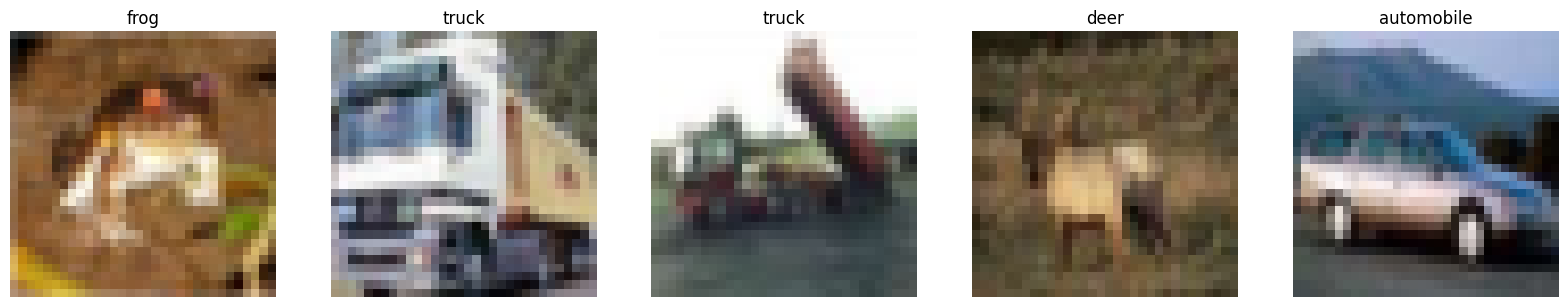

In [7]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

### 데이터 전처리 함수

In [8]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

### 데이터셋 준비

In [9]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()

print("Training dataset size:", train_ds_size)
print("Validation dataset size:", validation_ds_size)
print("Test dataset size:", test_ds_size)

Training dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000


In [10]:
batch_size = 32
buffer_size = 1000

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))

validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
                  .map(process_images)
                  .batch(batch_size=batch_size, drop_remainder=True))

In [11]:
for d in train_ds:
    print(d)
    break

(<tf.Tensor: shape=(32, 227, 227, 3), dtype=float32, numpy=
array([[[[-0.9790095 , -0.48853087, -0.8563898 ],
         [-0.9790095 , -0.48853087, -0.8563898 ],
         [-0.9790095 , -0.48853087, -0.8563898 ],
         ...,
         [-0.36591122, -0.04710012, -0.48853087],
         [-0.36591122, -0.04710012, -0.48853087],
         [-0.36591122, -0.04710012, -0.48853087]],

        [[-0.9790095 , -0.48853087, -0.8563898 ],
         [-0.9790095 , -0.48853087, -0.8563898 ],
         [-0.9790095 , -0.48853087, -0.8563898 ],
         ...,
         [-0.36591122, -0.04710012, -0.48853087],
         [-0.36591122, -0.04710012, -0.48853087],
         [-0.36591122, -0.04710012, -0.48853087]],

        [[-0.9790095 , -0.48853087, -0.8563898 ],
         [-0.9790095 , -0.48853087, -0.8563898 ],
         [-0.9790095 , -0.48853087, -0.8563898 ],
         ...,
         [-0.36591122, -0.04710012, -0.48853087],
         [-0.36591122, -0.04710012, -0.48853087],
         [-0.36591122, -0.04710012, -0.48853

### Alexnet 모델

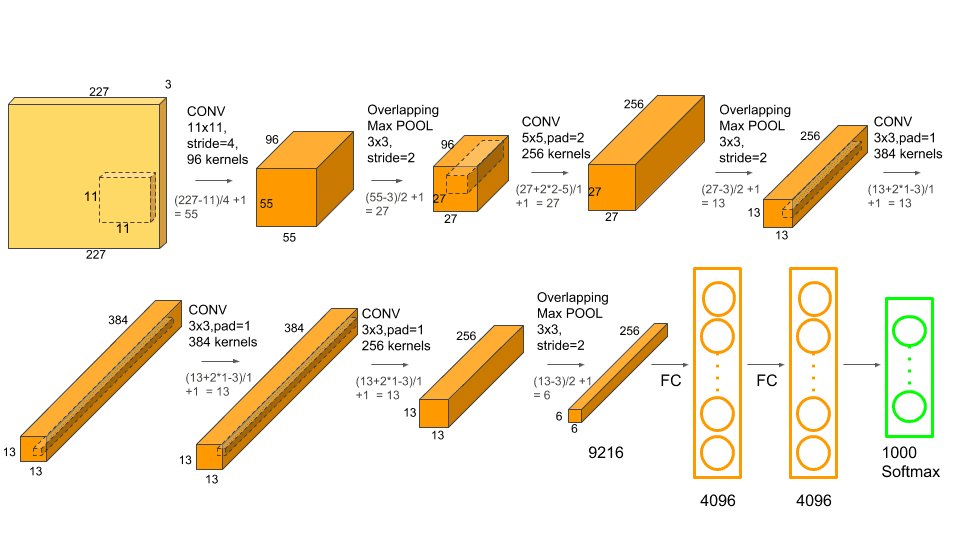

In [12]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(4096, input_shape=(227*227*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

#  output Layer
model.add(Dense(10))

model.add(Activation('softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 27, 27, 256)       0

### TensorBoard 로깅 디렉토리 설정

In [14]:
tensorboard = TensorBoard('logs/alexnet')

### 모델 컴파일

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001),
              metrics=['accuracy'])

### 모델 훈련

In [16]:
epochs = 30

model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          callbacks=[tensorboard])

Epoch 1/30
1406/1406 [==============================] - 92s 54ms/step - loss: 2.0251 - accuracy: 0.3508 - val_loss: 1.2415 - val_accuracy: 0.5683
Epoch 2/30
1406/1406 [==============================] - 75s 53ms/step - loss: 1.6197 - accuracy: 0.4621 - val_loss: 1.0459 - val_accuracy: 0.6398
Epoch 3/30
1406/1406 [==============================] - 75s 53ms/step - loss: 1.4013 - accuracy: 0.5288 - val_loss: 0.8954 - val_accuracy: 0.6921
Epoch 4/30
1406/1406 [==============================] - 75s 53ms/step - loss: 1.2366 - accuracy: 0.5794 - val_loss: 0.8097 - val_accuracy: 0.7198
Epoch 5/30
1406/1406 [==============================] - 75s 53ms/step - loss: 1.1153 - accuracy: 0.6186 - val_loss: 0.7281 - val_accuracy: 0.7496
Epoch 6/30
1406/1406 [==============================] - 75s 53ms/step - loss: 1.0113 - accuracy: 0.6526 - val_loss: 0.6385 - val_accuracy: 0.7772
Epoch 7/30
1406/1406 [==============================] - 76s 54ms/step - loss: 0.9335 - accuracy: 0.6778 - val_loss: 0.5621 -

In [17]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/logs/alexnet